In [324]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import numpy as np
import pandas as pd
import scipy.stats
import tensorflow as tf

import scanpy as sc
import matplotlib as mpl

print()
print("numpy version "+np.__version__)
print("tensorflow version "+tf.__version__)
#print("tensorflow_probability version "+tfp.__version__)


import batchglm.api as glm
import diffxpy.api as de

print("batchglm version "+glm.__version__)
print("diffpy version "+de.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

numpy version 1.18.5
tensorflow version 2.2.0
batchglm version v0.7.4
diffpy version v0.7.4


In [325]:
annot = sc.read_h5ad('/Users/derekbogdanoff/projects/XYZeq/new_h5s/Processed_Liver_All_Batches_mouse_deconV2_spatial.h5ad')

In [326]:
adata_matrix = sc.read_h5ad('/Users/derekbogdanoff/projects/XYZeq/new_h5s/Liver_All_Batches_mouse_deconV2_raw_counts.h5ad')

In [327]:
adata = adata_matrix[adata_matrix.obs.index.isin(annot.obs.index.to_list())]


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [328]:
##set annotations
adata.obs = annot.obs

adata.uns = annot.uns

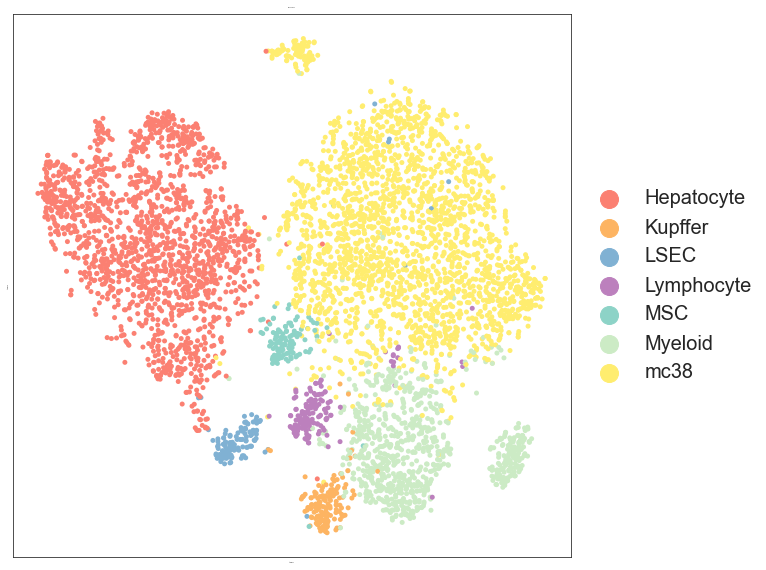

In [329]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 2
plt.rcParams['axes.titlesize'] = 2


sc.pl.tsne(adata,
          color=['CellType'],
        #  legend_loc = 'on data',
           s=100
          )



In [330]:
###define binary spatial annotations

def label_race(row):
   if row['prox_2'] >= 0.5 :
      return 'liver'
   if row['prox_2'] < 0.5 : 
      return 'tumor'
   else:
      return 'None'

In [331]:
### ..and apply them

adata.obs['tissue'] = adata.obs.apply(lambda row: label_race(row), axis=1)

In [332]:
##filter out human genes

adata = adata[:,adata.var_names.str.startswith('mm10_')]

In [333]:
##create log normalized data
adata_norm = sc.pp.log1p(adata, copy=True)

In [335]:
###generate size factors
### try this with R SCRAN - compare results with scanpy..?


size_factors = sc.pp.normalize_total(adata_norm,
                         inplace=False,
                         )['norm_factor']


adata_norm.obs['size_factors'] = pd.DataFrame(size_factors,
                                        index=adata_norm.obs.index)

In [336]:
#create celltype specific matrices

for i in adata.obs['CellType'].unique():
     locals()["adata_"+str(i)] = adata[adata.obs['CellType'] == i]
        
    
for i in adata_norm.obs['CellType'].unique():
     locals()["adata_norm_"+str(i)] = adata_norm[adata_norm.obs['CellType'] == i]
        

In [337]:
adata_norm.obs['CellType'].unique()

['Hepatocyte', 'mc38', 'Kupffer', 'MSC', 'Lymphocyte', 'Myeloid', 'LSEC']
Categories (7, object): ['Hepatocyte', 'mc38', 'Kupffer', 'MSC', 'Lymphocyte', 'Myeloid', 'LSEC']

In [459]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri

import anndata2ri



In [457]:
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [458]:
rpy2.__version__

'3.3.6'

In [453]:
# import rpy2.robjects.numpy2ri
# rpy2.robjects.numpy2ri.activate()

In [383]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
#.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
# library(slingshot)
# library(monocle)
# library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find

In [533]:
adata_norm.obs

,batch,n_counts,log_counts,n_genes,percent_mito_mouse,percent_mito_human,mouse_counts,human_counts,ratio,cell_call,...,CellType,__is_in_cluster__,barcode,X,Y,prox_1,prox_2,bins_1,tissue,size_factors
0,L10C,808.202087,6.694813,428,0.000000,0.000000e+00,763.485046,44.717220,1.232326,M,...,Hepatocyte,False,CACTGGCGGTATTAGA,6,-13.5,0.961538,0.801644,"(0.765, 0.809]",liver,404.887024
1,L10C,1045.261353,6.952023,507,0.000000,5.299168e-17,1025.530640,19.731436,1.715790,M,...,mc38,True,CCTTGTACAGGCATGA,17,-7.0,0.000000,0.727415,"(0.722, 0.765]",liver,510.488647
2,L10C,717.651733,6.575984,387,0.000000,0.000000e+00,707.671387,9.980301,1.850688,M,...,Kupffer,False,CACGACCTCACGACTA,8,-10.5,0.972222,0.888194,"(0.853, 0.896]",liver,367.265961
3,L10C,760.683838,6.634218,433,0.000000,0.000000e+00,728.789001,31.895189,1.358877,M,...,Hepatocyte,False,ATTGACCAGAAGATGC,9,-2.0,1.000000,0.915088,"(0.896, 0.94]",liver,396.491028
4,L10C,1022.485962,6.929993,581,0.097490,0.000000e+00,996.758911,25.727455,1.588193,M,...,mc38,True,GAGGTGATCTTCTCAA,15,-6.0,0.758621,0.820251,"(0.809, 0.853]",liver,540.216064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5429,L30C,527.605469,6.268349,304,0.000000,0.000000e+00,494.465576,33.139854,1.173785,M,...,Myeloid,False,CTGCTTCGGCCATCAG,15,-5.0,0.000000,0.428115,"(0.417, 0.461]",tumor,272.415161
5430,L30C,577.553955,6.358802,429,0.345282,0.000000e+00,557.849670,19.704298,1.451956,M,...,mc38,True,GCCAGTACTGCGTGTT,15,-13.0,0.272727,0.437233,"(0.417, 0.461]",tumor,345.522583
5431,L30C,871.832520,6.770598,514,0.000000,0.000000e+00,853.875061,17.957762,1.677142,M,...,mc38,True,TATAAGCCGACGACGC,12,-15.5,0.000000,0.519925,"(0.504, 0.548]",liver,471.371307
5432,L30C,1679.884521,7.426480,870,0.000000,0.000000e+00,1641.704712,38.178833,1.633472,M,...,mc38,True,CATGAACGGTTAAGCC,25,-18.0,0.000000,0.180736,"(0.156, 0.2]",tumor,849.245056


In [534]:
##make a count matriX for test
adata_test = adata_norm.copy()

adata_test.obs['n_genes'] = (adata_test.X > 0).sum(1) # recompute number of genes expressed per cell

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [412]:
## matrix indeices need to be integers for R . . .

adata_index = adata.obs.index



NameError: name 'df' is not defined

In [503]:
###replace indicies with integers
adata_test.obs = adata_test.obs.reindex(index = list(range(5434)))

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


In [504]:
###remove unstructered annotations until indicies can be found...
adata_test.uns = {}

In [415]:
adata.obs['CellType'].unique().tolist()

['Hepatocyte', 'mc38', 'Kupffer', 'MSC', 'Lymphocyte', 'Myeloid', 'LSEC']

In [520]:
%%R -i adata_test -o hepatocyte_de -o mc38_de

#-o hepatocyte_de

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(adata_test, class = "SingleCellAssay")




#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

#Create data subsets for liver and tumor subpopulations
sca_hepatocyte <- subset(sca, with(colData(sca), CellType=='Hepatocyte'))
sca_mc38 <- subset(sca, with(colData(sca), CellType=='mc38'))

#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca_hepatocyte))
print(dim(sca_mc38))
print("")


sca_hepatocyte_filt = sca_hepatocyte[rowSums(assay(sca_hepatocyte)) != 0, ]
sca_mc38_filt = sca_mc38[rowSums(assay(sca_mc38)) != 0, ]

print("Dimensions after subsetting:")
print(dim(sca_hepatocyte_filt))
print(dim(sca_mc38_filt))



#Define & run hurdle model - hepatocyte
zlmCond_hepatocyte <- zlm(formula = ~tissue + batch + n_genes, sca=sca_hepatocyte_filt)

summaryCond_hepatocyte <- summary(zlmCond_hepatocyte, doLRT='tissuetumor')
summaryDt_hepatocyte <- summaryCond_hepatocyte$datatable

result_hepatocyte <- merge(summaryDt_hepatocyte[contrast=='tissuetumor' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_hepatocyte[contrast=='tissuetumor' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_hepatocyte[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
hepatocyte_de = result_hepatocyte[result_hepatocyte$FDR<0.05,, drop=F]
hepatocyte_de = hepatocyte_de[order(hepatocyte_de$FDR),]






#Define & run hurdle model - mc38
zlmCond_mc38 <- zlm(formula = ~tissue + batch + n_genes, sca=sca_mc38_filt)

summaryCond_mc38 <- summary(zlmCond_mc38, doLRT='tissuetumor')
summaryDt_mc38 <- summaryCond_mc38$datatable

result_mc38 <- merge(summaryDt_mc38[contrast=='tissuetumor' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_mc38[contrast=='tissuetumor' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_mc38[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
mc38_de = result_mc38[result_mc38$FDR<0.05,, drop=F]
mc38_de = mc38_de[order(mc38_de$FDR),]




/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
R[write to console]: `fData` has no primerid.  I'll make something up.

R[write to console]: `cData` has no wellKey.  I'll make something up.

R[write to console]: Assuming data assay in position 1, with name X is log-transformed.



[1] "Dimensions before subsetting:"
[1] 24917  1711
[1] 24917  2361
[1] ""
[1] "Dimensions after subsetting:"
[1] 19467  1711
[1] 20903  2361


R[write to console]: 
R[write to console]:  Completed [--------------------------------------------]   0% with 0 failures
R[write to console]: 
R[write to console]:  Completed [--------------------------------------------]   1% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   1% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   2% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   3% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   3% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   4% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   5% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [====================>-----------------------]  48% with 0 failures
R[write to console]: 
R[write to console]:  Completed [====================>-----------------------]  49% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  49% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  50% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  51% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  51% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  52% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  53% with 0 failures
R[write to console]: 
R[write to console]:  Co

R[write to console]: 
R[write to console]:  Completed [=========================================>--]  97% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  97% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  98% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  99% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===========================================>]  99% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===========================================>] 100% with 0 failures
R[write to console]: 
R[write to console]:  Completed [============================================] 100% with 0 failures
                                                                              
R[write to console]: 
R[write to console]: 
Done!

R[write to conso

R[write to console]: 
R[write to console]:  Completed [=================>--------------------------]  42% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  42% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  43% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  44% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  44% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  45% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  46% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  47% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [======================================>-----]  90% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  90% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  91% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  92% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  92% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  93% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  94% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=========================================>--]  94% with 0 failures
R[write to console]: 
R[write to console]:  Co

R[write to console]: 
R[write to console]:  Completed [===============>----------------------------]  35% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===============>----------------------------]  36% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===============>----------------------------]  37% with 0 failures
R[write to console]: 
R[write to console]:  Completed [================>---------------------------]  38% with 0 failures
R[write to console]: 
R[write to console]:  Completed [================>---------------------------]  39% with 0 failures
R[write to console]: 
R[write to console]:  Completed [================>---------------------------]  40% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=================>--------------------------]  40% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=================>--------------------------]  41% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [====================================>-------]  83% with 0 failures
R[write to console]: 
R[write to console]:  Completed [====================================>-------]  84% with 0 failures
R[write to console]: 
R[write to console]:  Completed [====================================>-------]  85% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================================>------]  85% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================================>------]  86% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================================>------]  87% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================================>-----]  88% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================================>-----]  89% with 0 failures
R[write to console]: 
R[write to console]:  Co

R[write to console]: 
R[write to console]:  Completed [============>-------------------------------]  28% with 0 failures
R[write to console]: 
R[write to console]:  Completed [============>-------------------------------]  29% with 0 failures
R[write to console]: 
R[write to console]:  Completed [============>-------------------------------]  30% with 0 failures
R[write to console]: 
R[write to console]:  Completed [============>-------------------------------]  31% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=============>------------------------------]  31% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=============>------------------------------]  32% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=============>------------------------------]  33% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==============>-----------------------------]  33% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [=================================>----------]  76% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=================================>----------]  77% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=================================>----------]  78% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================================>---------]  78% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================================>---------]  79% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================================>---------]  80% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================================>---------]  81% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================================>--------]  81% with 0 failures
R[write to console]: 
R[write to console]:  Co

In [521]:
hepatocyte_de

,primerid,Pr(>Chisq),coef,FDR
1,mm10_Gmcl1,1.691476e-11,0.008782,3.292795e-07
2,mm10_1700123O12Rik,2.670294e-10,0.003030,2.599130e-06
3,mm10_Dpyd,1.127902e-08,-0.294198,5.489218e-05
4,mm10_Rnf167,1.126622e-08,0.065295,5.489218e-05
5,mm10_Ubxn8,1.606948e-08,-0.039826,6.256491e-05
...,...,...,...,...
69,mm10_Gck,1.866676e-04,0.144270,4.977887e-02
70,mm10_Hpx,1.801752e-04,0.199619,4.977887e-02
71,mm10_Peg3,1.798788e-04,0.216216,4.977887e-02
72,mm10_Phf10,1.840086e-04,0.001365,4.977887e-02


In [518]:

mc38_de['-logQ'] = -np.log(mc38_de['FDR'])

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [532]:
adata_norm[adata_norm.obs['CellType'] == 'Hepatocyte']

AssertionError: Don’t call _normalize_index with non-categorical/string names

In [523]:
%%R -i adata_test -o Myeloid_de -o Lymphocyte_de

#-o Myeloid_de

#Convert SingleCellExperiment to SingleCellAssay type as required by MAST
sca <- SceToSingleCellAssay(adata_test, class = "SingleCellAssay")




#Scale Gene detection rate
colData(sca)$n_genes = scale(colData(sca)$n_genes)

#Create data subsets for liver and tumor subpopulations
sca_Myeloid <- subset(sca, with(colData(sca), CellType=='Myeloid'))
sca_Lymphocyte <- subset(sca, with(colData(sca), CellType=='Lymphocyte'))

#Filter out non-expressed genes in the subsets
print("Dimensions before subsetting:")
print(dim(sca_Myeloid))
print(dim(sca_Lymphocyte))
print("")


sca_Myeloid_filt = sca_Myeloid[rowSums(assay(sca_Myeloid)) != 0, ]
sca_Lymphocyte_filt = sca_Lymphocyte[rowSums(assay(sca_Lymphocyte)) != 0, ]

print("Dimensions after subsetting:")
print(dim(sca_Myeloid_filt))
print(dim(sca_Lymphocyte_filt))



#Define & run hurdle model - Myeloid
zlmCond_Myeloid <- zlm(formula = ~tissue + batch + n_genes, sca=sca_Myeloid_filt)

summaryCond_Myeloid <- summary(zlmCond_Myeloid, doLRT='tissuetumor')
summaryDt_Myeloid <- summaryCond_Myeloid$datatable

result_Myeloid <- merge(summaryDt_Myeloid[contrast=='tissuetumor' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_Myeloid[contrast=='tissuetumor' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_Myeloid[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
Myeloid_de = result_Myeloid[result_Myeloid$FDR<0.05,, drop=F]
Myeloid_de = Myeloid_de[order(Myeloid_de$FDR),]






#Define & run hurdle model - Lymphocyte
zlmCond_Lymphocyte <- zlm(formula = ~tissue + batch + n_genes, sca=sca_Lymphocyte_filt)

summaryCond_Lymphocyte <- summary(zlmCond_Lymphocyte, doLRT='tissuetumor')
summaryDt_Lymphocyte <- summaryCond_Lymphocyte$datatable

result_Lymphocyte <- merge(summaryDt_Lymphocyte[contrast=='tissuetumor' & component=='H',.(primerid, `Pr(>Chisq)`)], #P-vals
                 summaryDt_Lymphocyte[contrast=='tissuetumor' & component=='logFC', .(primerid, coef)],
                 by='primerid') #logFC coefficients

#Correct for multiple testing (FDR correction) and filtering
result_Lymphocyte[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
Lymphocyte_de = result_Lymphocyte[result_Lymphocyte$FDR<0.05,, drop=F]
Lymphocyte_de = Lymphocyte_de[order(Lymphocyte_de$FDR),]

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
R[write to console]: `fData` has no primerid.  I'll make something up.

R[write to console]: `cData` has no wellKey.  I'll make something up.

R[write to console]: Assuming data assay in position 1, with name X is log-transformed.



[1] "Dimensions before subsetting:"
[1] 24917   822
[1] 24917   150
[1] ""
[1] "Dimensions after subsetting:"
[1] 17325   822
[1] 12044   150


R[write to console]: 
R[write to console]:  Completed [--------------------------------------------]   0% with 0 failures
R[write to console]: 
R[write to console]:  Completed [--------------------------------------------]   1% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   1% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   2% with 0 failures
R[write to console]: 
R[write to console]:  Completed [>-------------------------------------------]   3% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   3% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   4% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=>------------------------------------------]   5% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [====================>-----------------------]  48% with 0 failures
R[write to console]: 
R[write to console]:  Completed [====================>-----------------------]  49% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  49% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  50% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================>----------------------]  51% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  51% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  52% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================>---------------------]  53% with 0 failures
R[write to console]: 
R[write to console]:  Co

R[write to console]: 
R[write to console]:  Completed [=========================================>--]  97% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  97% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  98% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==========================================>-]  99% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===========================================>]  99% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===========================================>] 100% with 0 failures
R[write to console]: 
R[write to console]:  Completed [============================================] 100% with 0 failures
                                                                              
R[write to console]: 
R[write to console]: 
Done!

R[write to conso

R[write to console]: 
R[write to console]:  Completed [=================>--------------------------]  42% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  42% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  43% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================>-------------------------]  44% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  44% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  45% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  46% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================>------------------------]  47% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [======================================>-----]  90% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  90% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  91% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=======================================>----]  92% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  92% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  93% with 0 failures
R[write to console]: 
R[write to console]:  Completed [========================================>---]  94% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=========================================>--]  94% with 0 failures
R[write to console]: 
R[write to console]:  Co

R[write to console]: 
R[write to console]:  Completed [===============>----------------------------]  35% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===============>----------------------------]  36% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===============>----------------------------]  37% with 0 failures
R[write to console]: 
R[write to console]:  Completed [================>---------------------------]  38% with 0 failures
R[write to console]: 
R[write to console]:  Completed [================>---------------------------]  39% with 0 failures
R[write to console]: 
R[write to console]:  Completed [================>---------------------------]  40% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=================>--------------------------]  40% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=================>--------------------------]  41% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [====================================>-------]  83% with 0 failures
R[write to console]: 
R[write to console]:  Completed [====================================>-------]  84% with 0 failures
R[write to console]: 
R[write to console]:  Completed [====================================>-------]  85% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================================>------]  85% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================================>------]  86% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=====================================>------]  87% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================================>-----]  88% with 0 failures
R[write to console]: 
R[write to console]:  Completed [======================================>-----]  89% with 0 failures
R[write to console]: 
R[write to console]:  Co

R[write to console]: 
R[write to console]:  Completed [============>-------------------------------]  28% with 0 failures
R[write to console]: 
R[write to console]:  Completed [============>-------------------------------]  29% with 0 failures
R[write to console]: 
R[write to console]:  Completed [============>-------------------------------]  30% with 0 failures
R[write to console]: 
R[write to console]:  Completed [============>-------------------------------]  31% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=============>------------------------------]  31% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=============>------------------------------]  32% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=============>------------------------------]  33% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==============>-----------------------------]  33% with 0 failures
R[write to console]: 
R[

R[write to console]:  Completed [=================================>----------]  76% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=================================>----------]  77% with 0 failures
R[write to console]: 
R[write to console]:  Completed [=================================>----------]  78% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================================>---------]  78% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================================>---------]  79% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================================>---------]  80% with 0 failures
R[write to console]: 
R[write to console]:  Completed [==================================>---------]  81% with 0 failures
R[write to console]: 
R[write to console]:  Completed [===================================>--------]  81% with 0 failures
R[write to console]: 
R[write to console]:  Co

In [525]:
Lymphocyte_de

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,primerid,Pr(>Chisq),coef,FDR


In [509]:
adata_test.obs['tissue']

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       liver
1       liver
2       liver
3       liver
4       liver
        ...  
5429    tumor
5430    tumor
5431    liver
5432    tumor
5433    tumor
Name: tissue, Length: 5434, dtype: object

In [462]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [463]:
import scanpy.datasets as scd
adata_paul = scd.paul15()

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'paul15_clusters' as categorical
/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.uns` of view, copying.


In [472]:
adata_paul.

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


""
0610007L01Rik
0610009O20Rik
0610010K14Rik
0910001L09Rik
1100001G20Rik
...
mKIAA1027
mKIAA1575
mKIAA1994
rp9


In [499]:
%%R -i adata_paul
adata_paul  # class: SingleCellExperiment ...

class: SingleCellExperiment 
dim: 3451 2730 
metadata(0):
assays(1): X
rownames(3451): 0610007L01Rik 0610009O20Rik ... rp9 slc43a2
rowData names(0):
colnames(2730): 0 1 ... 2728 2729
colData names(1): paul15_clusters
reducedDimNames(0):
altExpNames(0):


In [498]:
adata_paul.uns = {}


In [ ]:
#AnnData(exprs, obs, var, uns, obsm or None, layers=layers)

In [488]:
adata.uns_keys()

['CellType_colors',
 'batch_colors',
 'dendrogram_CellType',
 'leiden',
 'leiden_colors',
 'neighbors',
 'pca',
 'rank_genes_groups',
 'rank_genes_groups_filtered',
 'tsne_density_params',
 'umap']

In [489]:
adata.uns['umap']

{'params': {'a': 0.08842489707379363, 'b': 0.8950609626866735}}

In [501]:
%%R -i adata_test
adata_test

class: SingleCellExperiment 
dim: 24917 5434 
metadata(0):
assays(1): X
rownames(24917): mm10_Xkr4 mm10_Gm1992 ... mm10_Vmn2r122
  mm10_CAAA01147332.1
rowData names(0):
colnames(5434): 0 1 ... 5432 5433
colData names(24): batch n_counts ... tissue size_factors
reducedDimNames(3): PCA TSNE UMAP
altExpNames(0):


In [378]:


hepatocyte_norm_DE = de.test.wald(
    data=adata_norm_Hepatocyte.X,
    
    sample_description=adata_norm_Hepatocyte.obs,
    
     gene_names=adata_norm_Hepatocyte.var_names,
#     grouping=adata_norm_Hepatocyte.obs.tissue

     formula_loc="~ 1 + tissue + batch",
     formula_scale="~ 1 + batch",
     factor_loc_totest="tissue",
    
     #size_factors='size_factors',
    
    
    ###convert to float64
    dtype='float64',
    backend='numpy'

)

training location model: True
training scale model: True


ValueError: cannot model more than one scale parameter with numpy backend right now.

In [339]:
myeloid_norm_DE = de.test.wald(
    data=adata_norm_Myeloid.X,
    
    sample_description=adata_norm_Myeloid.obs,
    
     gene_names=adata_norm_Myeloid.var_names,
#     grouping=adata_norm_Hepatocyte.obs.tissue

     formula_loc="~ 1 + tissue",
     formula_scale="~ 1",
     factor_loc_totest="tissue",
    
     #size_factors='size_factors',
    
    
    ###convert to float64
    dtype='float64',
    backend='numpy'

)

training location model: False
training scale model: True
iter   0: ll=13581690.775317
iter   1: ll=13581690.775317, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=1595581.203974, converged: 30.47% (loc: 30.47%, scale update: True), in 78.78sec
iter   3: ll=1595581.203974, converged: 30.47% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=1523770.528378, converged: 83.35% (loc: 83.35%, scale update: True), in 56.74sec
iter   5: ll=1523770.528378, converged: 83.35% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=1512424.845922, converged: 95.81% (loc: 95.81%, scale update: True), in 35.35sec
iter   7: ll=1512424.845922, converged: 95.81% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=1509152.583504, converged: 99.10% (loc: 99.10%, scale update: True), in 39.98sec
iter   9: ll=1509152.583504, converged: 99.10% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=1508734.762203, converged: 99.83% (loc: 99.83%, s

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/dask/array/core.py:2707: RuntimeWarning: divide by zero encountered in true_divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


In [341]:
mc38_norm_DE = de.test.wald(
    data=adata_norm_mc38,
    
    sample_description=adata_norm_mc38.obs,
    
     gene_names=adata_norm_mc38.var_names,
#     grouping=adata_norm_Hepatocyte.obs.tissue

     formula_loc="~ 1 + tissue",
     formula_scale="~ 1",
     factor_loc_totest="tissue",
    
     #size_factors='size_factors',
    
    
    ###convert to float64
    dtype='float64',
    backend='numpy'

)

training location model: False
training scale model: True
iter   0: ll=37712228.452835
iter   1: ll=37712228.452835, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=5325070.338956, converged: 16.13% (loc: 16.13%, scale update: True), in 115.13sec
iter   3: ll=5325070.338956, converged: 16.13% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=5137530.213010, converged: 81.64% (loc: 81.64%, scale update: True), in 101.45sec
iter   5: ll=5137530.213010, converged: 81.64% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=5108237.964060, converged: 95.30% (loc: 95.30%, scale update: True), in 46.90sec
iter   7: ll=5108237.964060, converged: 95.30% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=5102616.675212, converged: 99.11% (loc: 99.11%, scale update: True), in 45.12sec
iter   9: ll=5102616.675212, converged: 99.11% (loc: 100.00%, scale update: False), in 0.00sec
iter  10: ll=5101459.514588, converged: 99.82% (loc: 99.82%,

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/dask/array/core.py:2707: RuntimeWarning: divide by zero encountered in true_divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


In [342]:
###define significance annotations

def significance(row):
   if row['qval'] <= 0.05 and row['log2fc'] > 0.5:
      return 'liver'
   if row['qval'] <= 0.05 and row['log2fc'] < -0.5:
      return 'tumor'
   else:
      return 'insignificant'
    

In [350]:
# myeloid_norm_df = myeloid_norm_DE.summary()
# mc38_norm_df = mc38_norm_DE.summary()
# hepatocyte_norm_df = hepatocyte_norm_DE.summary()
# # lymphocyte_df = lymphocyte_DE.summary()
# # MSC_df = MSC_DE.summary()

In [351]:
myeloid_norm_df = myeloid_norm_DE.summary()
mc38_norm_df = mc38_norm_DE.summary()
hepatocyte_norm_df = hepatocyte_norm_DE.summary()
lymphocyte_norm_df = lymphocyte_norm_DE.summary()
MSC_norm_df = MSC_norm_DE.summary()

In [356]:
myeloid_norm_df['significance'] =  myeloid_norm_df.apply(lambda row: significance(row), axis=1)
mc38_norm_df['significance'] =  mc38_norm_df.apply(lambda row: significance(row), axis=1)
hepatocyte_norm_df['significance'] =  hepatocyte_norm_df.apply(lambda row: significance(row), axis=1)
lymphocyte_df['significance'] =  lymphocyte_df.apply(lambda row: significance(row), axis=1)

MSC_df['significance'] = MSC_df.apply(lambda row: significance(row), axis=1)



In [357]:
#define valcano colormap

valcano_pal = ["#34495e", 
               "#1f77b4",
               "#ff7f0e", 
              ]

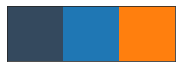

In [358]:
sns.palplot(valcano_pal)

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[(0.0, 3.0)]

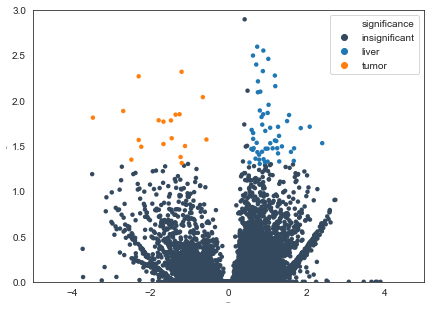

In [368]:
plt.rcParams['figure.figsize'] = 7,5
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.markerscale'] = 1


g = sns.scatterplot(data=myeloid_norm_df,
                x='log2fc',
                y=-np.log10(myeloid_norm_df.qval),
                s=20,
                linewidth=0,
                hue='significance',
                palette=valcano_pal
                

               )

g.set(xlim=(-5,5))
g.set(ylim=(0,3))






In [374]:
myeloid_norm_df[myeloid_norm_df.significance != 'insignificant'].sort_values(by='qval').to_csv('myeloid_norm_DE.csv')

In [375]:
mc38_norm_df[mc38_norm_df.significance != 'insignificant'].sort_values(by='qval').to_csv('mc38_norm_DE.csv')

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[(-5.0, 5.0)]

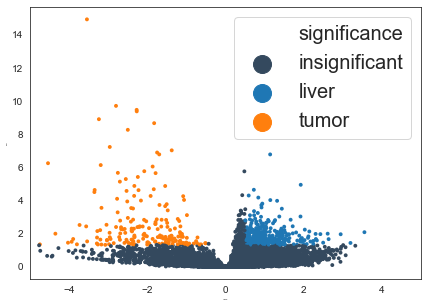

In [301]:
plt.rcParams['figure.figsize'] = 7,5

g = sns.scatterplot(data=mc38_df,
                x='log2fc',
                y=-np.log10(mc38_df.qval),
                s=15,
                linewidth=0,
                hue='significance',
                palette=valcano_pal
                

               )

g.set(xlim=(-5,5))

In [241]:
#define valcano colormap

valcano_pal = ["#34495e", #darkGrey
               "#ff7f0e", #orange
               "#1f77b4", #blue
              ]

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[(-5.0, 5.0)]

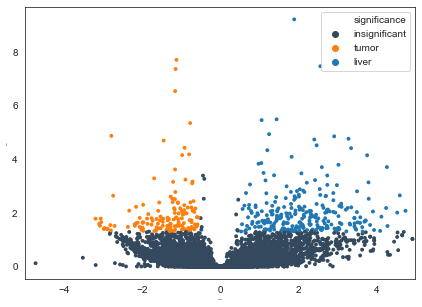

In [244]:
plt.rcParams['figure.figsize'] = 7,5
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.markerscale'] = 1




g = sns.scatterplot(data=hepatocyte_df,
                x='log2fc',
                y=-np.log10(hepatocyte_df.qval),
                s=15,
                linewidth=0,
                hue='significance',
                palette=valcano_pal
                

               )

g.set(xlim=(-5,5))

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[(-5.0, 5.0)]

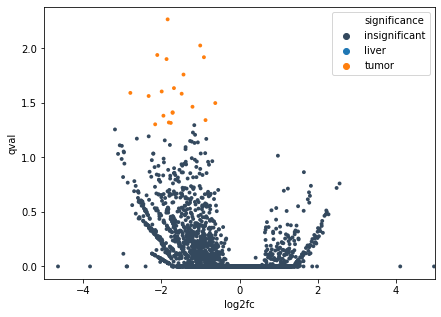

In [117]:
plt.rcParams['figure.figsize'] = 7,5

g = sns.scatterplot(data=lymphocyte_df,
                x='log2fc',
                y=-np.log10(lymphocyte_df.qval),
                s=15,
                linewidth=0,
                hue='significance',
                palette=valcano_pal
                

               )

g.set(xlim=(-5,5))

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[(-5.0, 5.0)]

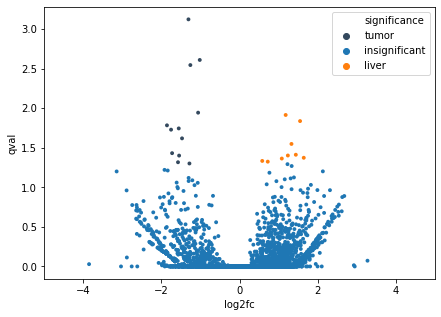

In [121]:
plt.rcParams['figure.figsize'] = 7,5

g = sns.scatterplot(data=MSC_df,
                x='log2fc',
                y=-np.log10(MSC_df.qval),
                s=15,
                linewidth=0,
                hue='significance',
                palette=valcano_pal
                

               )

g.set(xlim=(-5,5))

In [223]:
#create batch specific matrices

for i in adata.obs['batch'].unique():
     locals()["adata_"+str(i)] = adata[adata.obs['batch'] == i]
        
    
# for i in adata_norm.obs['CellType'].unique():
#      locals()["adata_norm_"+str(i)] = adata_norm[adata_norm.obs['CellType'] == i]
        

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 2325 × 24917
    obs: 'batch', 'n_counts', 'log_counts', 'n_genes', 'percent_mito_mouse', 'percent_mito_human', 'mouse_counts', 'human_counts', 'ratio', 'cell_call', 'contam_post', 'contam_init', 'tsne_density', 'leiden', 'CellType', '__is_in_cluster__', 'barcode', 'X', 'Y', 'prox_1', 'prox_2', 'bins_1', 'tissue', 'size_factors'
    uns: 'CellType_colors', 'batch_colors', 'dendrogram_CellType', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'rank_genes_groups_filtered', 'tsne_density_params', 'umap', 'tissue_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [274]:
adata_batch1 = adata[adata.obs.batch == 'L10C']
adata_batch2 = adata[adata.obs.batch == 'L20C']
adata_batch3 = adata[adata.obs.batch == 'L20T']
adata_batch4 = adata[adata.obs.batch == 'L30C']

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [ ]:
plt.rcParams['figure.figsize'] = [20, 9]

plt.rcParams['legend.fontsize'] = 30
plt.rcParams['legend.markerscale'] = 3
plt.rcParams['axes.labelsize'] = 0
plt.rcParams['axes.titlesize'] = 30



sns.set_style("white", {'axes.grid' : False})

g = sns.scatterplot(data=adata_batch1.obs.groupby(['barcode','X','Y']).sum().reset_index(),
                x='X',
                y='Y',
                marker="H",
                s=1000,
                hue=np.log10(adata_batch1.obs.groupby(['barcode','X','Y']).sum().n_counts.tolist()),
                palette='magma',
                legend='brief'
                        ###for solid colors:
                #c=[cell_type_color]#[adata_batch1[adata_batch1.obs.CellType == i].uns['CellType_colors'].item()]

               )

points = g.get_children()[1]

points.cmap=mpl.cm.magma
plt.colorbar(mappable=points,)

In [276]:
adata_batch2 = adata[adata.obs['batch'] == 'L20C']

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [279]:
adata_batch2.obs.groupby(['barcode','X','Y']).sum()

n_counts  log_counts  n_genes  percent_mito_mouse  \
barcode          X  Y                                                          
AGACGTCCTCCGCCTA 2  -18.5       NaN         NaN      NaN                 NaN   
                    -18.0       NaN         NaN      NaN                 NaN   
                    -17.5       NaN         NaN      NaN                 NaN   
                    -17.0       NaN         NaN      NaN                 NaN   
                    -16.5       NaN         NaN      NaN                 NaN   
...                             ...         ...      ...                 ...   
TTGTCACGTGTGCTCA 34 -4.5        NaN         NaN      NaN                 NaN   
                    -4.0        NaN         NaN      NaN                 NaN   
                    -3.5        NaN         NaN      NaN                 NaN   
                    -3.0        NaN         NaN      NaN                 NaN   
                    -2.5        NaN         NaN      NaN                 NaN   

                           percent_mito_human  mouse_counts  human_counts  \
barcode          X  Y                                                       
AGACGTCCTCCGCCTA 2  -18.5                 NaN           NaN           NaN   
                    -18.0                 NaN           NaN           NaN   
                    -17.5                 NaN           NaN           NaN   
                    -17.0                 NaN           NaN           NaN   
                    -16.5                 NaN           NaN           NaN   
...                                       ...           ...           ...   
TTGTCACGTGTGCTCA 34 -4.5                  NaN           NaN           NaN   
                    -4.0                  NaN           NaN           NaN   
                    -3.5                  NaN           NaN           NaN   
                    -3.0                  NaN           NaN           NaN   
                    -2.5                  NaN           NaN           NaN   

                           ratio  contam_post  contam_init  tsne_density  \
barcode          X  Y                                                      
AGACGTCCTCCGCCTA 2  -18.5    NaN          NaN          NaN           NaN   
                    -18.0    NaN          NaN          NaN           NaN   
                    -17.5    NaN          NaN          NaN           NaN   
                    -17.0    NaN          NaN          NaN           NaN   
                    -16.5    NaN          NaN          NaN           NaN   
...                          ...          ...          ...           ...   
TTGTCACGTGTGCTCA 34 -4.5     NaN          NaN          NaN           NaN   
                    -4.0     NaN          NaN          NaN           NaN   
                    -3.5     NaN          NaN          NaN           NaN   
                    -3.0     NaN          NaN          NaN           NaN   
                    -2.5     NaN          NaN          NaN           NaN   

                           prox_1  prox_2  size_factors  
barcode          X  Y                                    
AGACGTCCTCCGCCTA 2  -18.5     NaN     NaN           NaN  
                    -18.0     NaN     NaN           NaN  
                    -17.5     NaN     NaN           NaN  
                    -17.0     NaN     NaN           NaN  
                    -16.5     NaN     NaN           NaN  
...                           ...     ...           ...  
TTGTCACGTGTGCTCA 34 -4.5      NaN     NaN           NaN  
                    -4.0      NaN     NaN           NaN  
                    -3.5      NaN     NaN           NaN  
                    -3.0      NaN     NaN           NaN  
                    -2.5      NaN     NaN           NaN  

[284229 rows x 14 columns]

In [126]:
adata_norm_TAM = adata_norm_Myeloid[adata_norm_Myeloid.obs.prox_2 < 0.5]

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [283]:
###define binary spatial annotations

def label_race_2(row):
   if row['prox_2'] >= 0.4 :
      return 'outer'
   if row['prox_2'] < 0.4 : 
      return 'inner'
   else:
      return 'None'

In [284]:
adata_norm_TAM.obs['tissue_2'] = adata_norm_TAM.obs.apply(lambda row: label_race_2(row), axis=1)

In [285]:
adata_norm_TAM.obs['tissue_2'].value_counts()

inner    352
outer    267
Name: tissue_2, dtype: int64

In [286]:
TAM_norm_DE = de.test.wald(
    data=adata_norm_TAM.X,
    
    sample_description=adata_norm_TAM.obs,
    
     gene_names=adata_norm_TAM.var_names,
#     grouping=adata_norm_Hepatocyte.obs.tissue

     formula_loc="~ 1 + tissue_2",
     formula_scale="~ 1",
     factor_loc_totest="tissue_2",
    
     #size_factors='size_factors',
    
    
    ###convert to float64
    dtype='float64',
    backend='numpy'
    
    
)

training location model: False
training scale model: True
iter   0: ll=10861502.590175
iter   1: ll=10861502.590175, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
iter   2: ll=1191847.356787, converged: 33.51% (loc: 33.51%, scale update: True), in 63.55sec
iter   3: ll=1191847.356787, converged: 33.51% (loc: 100.00%, scale update: False), in 0.00sec
iter   4: ll=1141305.080988, converged: 85.88% (loc: 85.88%, scale update: True), in 48.85sec
iter   5: ll=1141305.080988, converged: 85.88% (loc: 100.00%, scale update: False), in 0.00sec
iter   6: ll=1130497.122017, converged: 96.43% (loc: 96.43%, scale update: True), in 41.30sec
iter   7: ll=1130497.122017, converged: 96.43% (loc: 100.00%, scale update: False), in 0.00sec
iter   8: ll=1129042.305799, converged: 99.30% (loc: 99.30%, scale update: True), in 42.51sec
iter   9: ll=1129042.305799, converged: 99.30% (loc: 100.00%, scale update: False), in 0.00sec


KeyboardInterrupt: 

In [145]:
TAM_df = TAM_norm_DE.summary()
TAM_df['significance'] =  TAM_df.apply(lambda row: significance(row), axis=1)

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[(-5.0, 5.0)]

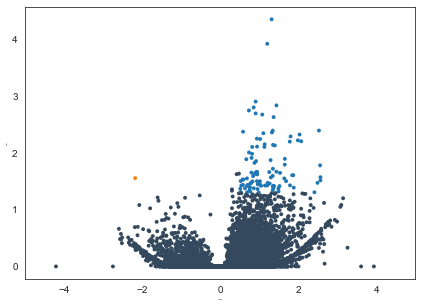

In [293]:
plt.rcParams['figure.figsize'] = 7,5

g = sns.scatterplot(data=TAM_df,
                x='log2fc',
                y=-np.log10(TAM_df.qval),
                s=15,
                linewidth=0,
                hue='significance',
                palette=valcano_pal,
                    legend=False
                

               )

g.set(xlim=(-5,5))

In [150]:
TAM_df[TAM_df['significance'] == 'liver']

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll,significance
21,mm10_Gm26901,0.000000,0.000000,283.913085,0.003999,False,6.461305e-03,283.913085,2.222759e-162,-29.350510,liver
25,mm10_Adhfe1,0.000000,0.000000,283.913085,0.006594,False,9.692350e-03,283.913085,2.222759e-162,-44.195266,liver
28,mm10_Vcpip1,0.002354,0.013928,0.919791,0.081635,False,1.648395e-10,0.919791,3.024120e-01,-174.231006,liver
31,mm10_Mcmdc2,0.000000,0.000000,283.913085,0.002032,False,4.064041e-03,283.913085,2.222759e-162,-17.210172,liver
58,mm10_Sbspon,0.000000,0.000000,283.913085,0.001106,False,2.807434e-03,283.913085,2.222759e-162,-7.851252,liver
...,...,...,...,...,...,...,...,...,...,...,...
24839,mm10_Ccdc172,0.000000,0.000000,283.913085,0.001120,False,5.051765e-03,283.913085,2.222759e-162,0.000000,liver
24843,mm10_Pnliprp2,0.000000,0.000000,283.913085,0.001112,False,2.224361e-03,283.913085,2.222759e-162,-9.447386,liver
24845,mm10_Hspa12a,0.000000,0.000000,283.913085,0.001073,False,4.578109e-03,283.913085,2.222759e-162,0.000000,liver
24860,mm10_Gm28351,0.000000,0.000000,283.913085,0.001120,False,2.239087e-03,283.913085,2.222759e-162,-9.511823,liver


In [204]:
adata_norm_Hepatocyte[adata_norm_Hepatocyte.obs['tissue'] == 'liver'].X

ArrayView([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
            0.       ],
           [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
            0.       ],
           [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
            0.       ],
           ...,
           [0.       , 0.       , 0.       , ..., 1.0978097, 0.       ,
            0.       ],
           [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
            0.       ],
           [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
            0.       ]], dtype=float32)

ArrayView([[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [203]:
###perfrom wilcoxon test

hep_wilcox = de.stats.mann_whitney_u_test(
    x0=adata_norm_Hepatocyte[adata_norm_Hepatocyte.obs['tissue'] == 'liver'].X,
    x1=adata_norm_Hepatocyte[adata_norm_Hepatocyte.obs['tissue'] == 'tumor'].X
#     data=adata_norm_MSC.X,
    
#     sample_description=adata_norm_MSC.obs,
    
#      gene_names=adata_norm_MSC.var_names,
# #     grouping=adata_norm_Hepatocyte.obs.tissue

#      formula_loc="~ 1 + tissue",
#      formula_scale="~ 1",
#      factor_loc_totest="tissue",
    
#      #size_factors='size_factors',
    
    
#     ###convert to float64
#     dtype='float64',
#     backend='numpy'

)

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


ValueError: All numbers are identical in mannwhitneyu

In [158]:
continuous_test = de.test. continuous_1d(
    data=adata_norm_TAM.X,
    
    sample_description=adata_norm_TAM.obs,
    
     gene_names=adata_norm_TAM.var_names,
#     grouping=adata_norm_Hepatocyte.obs.tissue

     formula_loc="~ 1 + prox_2",
     formula_scale="~ 1",
     factor_loc_totest="prox_2",
     continuous='prox_2',
     #size_factors='size_factors',
    
    
    ###convert to float64
    dtype='float64',
    backend='numpy'
    
    
)

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))


training location model: True
training scale model: True
iter   0: ll=10850348.166224
iter   1: ll=10806552.144979, converged: 0.00% (loc: 35.65%, scale update: False), in 3.70sec
caught 29 linalg singular matrix errors
iter   2: ll=10799597.215901, converged: 0.00% (loc: 59.92%, scale update: False), in 3.42sec
iter   3: ll=10797594.540542, converged: 0.00% (loc: 59.92%, scale update: False), in 3.14sec
iter   4: ll=10796666.878774, converged: 0.00% (loc: 61.06%, scale update: False), in 2.77sec
iter   5: ll=10796043.647494, converged: 0.00% (loc: 66.28%, scale update: False), in 3.12sec
iter   6: ll=1217900.784644, converged: 33.50% (loc: 33.50%, scale update: True), in 85.09sec
caught 28 linalg singular matrix errors
iter   7: ll=1208693.558484, converged: 33.50% (loc: 51.82%, scale update: False), in 3.89sec
iter   8: ll=1207136.259365, converged: 33.50% (loc: 56.38%, scale update: False), in 4.21sec
iter   9: ll=1206418.191131, converged: 33.50% (loc: 67.50%, scale update: False),

iter  77: ll=1132017.836866, converged: 99.78% (loc: 99.90%, scale update: False), in 0.46sec
iter  78: ll=1132012.246441, converged: 99.83% (loc: 99.83%, scale update: True), in 32.60sec
iter  79: ll=1132012.245831, converged: 99.83% (loc: 99.88%, scale update: False), in 0.55sec
iter  80: ll=1132012.245626, converged: 99.83% (loc: 99.90%, scale update: False), in 0.46sec
iter  81: ll=1132012.245460, converged: 99.83% (loc: 99.90%, scale update: False), in 0.44sec
iter  82: ll=1132012.245324, converged: 99.83% (loc: 99.90%, scale update: False), in 0.42sec
iter  83: ll=1132012.245210, converged: 99.83% (loc: 99.91%, scale update: False), in 0.87sec
iter  84: ll=1132012.245074, converged: 99.88% (loc: 99.88%, scale update: True), in 42.28sec
iter  85: ll=1132012.244555, converged: 99.88% (loc: 99.90%, scale update: False), in 0.90sec
iter  86: ll=1132012.244413, converged: 99.88% (loc: 99.91%, scale update: False), in 0.73sec
iter  87: ll=1132012.244299, converged: 99.88% (loc: 99.91%,

iter 163: ll=1132012.238903, converged: 99.96% (loc: 99.98%, scale update: False), in 0.35sec
iter 164: ll=1132012.238831, converged: 99.96% (loc: 99.98%, scale update: False), in 0.32sec
iter 165: ll=1132012.238784, converged: 99.96% (loc: 99.98%, scale update: False), in 0.32sec
iter 166: ll=1132012.238753, converged: 99.96% (loc: 99.98%, scale update: False), in 0.31sec
iter 167: ll=1132012.238733, converged: 99.96% (loc: 99.98%, scale update: False), in 0.31sec
iter 168: ll=1132012.238565, converged: 99.97% (loc: 99.97%, scale update: True), in 35.93sec
iter 169: ll=1132012.238421, converged: 99.97% (loc: 99.98%, scale update: False), in 0.38sec
iter 170: ll=1132012.238329, converged: 99.97% (loc: 99.98%, scale update: False), in 0.35sec
iter 171: ll=1132012.238270, converged: 99.97% (loc: 99.98%, scale update: False), in 0.39sec
iter 172: ll=1132012.238233, converged: 99.97% (loc: 99.98%, scale update: False), in 0.34sec
iter 173: ll=1132012.238209, converged: 99.97% (loc: 99.98%,

iter 251: ll=1132012.216819, converged: 99.99% (loc: 100.00%, scale update: False), in 0.37sec
iter 252: ll=1132012.216784, converged: 99.99% (loc: 99.99%, scale update: True), in 0.36sec
iter 253: ll=1132012.216767, converged: 99.99% (loc: 99.99%, scale update: False), in 0.31sec
iter 254: ll=1132012.216764, converged: 99.99% (loc: 99.99%, scale update: False), in 0.31sec
iter 255: ll=1132012.216764, converged: 99.99% (loc: 100.00%, scale update: False), in 0.31sec
iter 256: ll=1132012.216764, converged: 99.99% (loc: 100.00%, scale update: False), in 0.35sec
iter 257: ll=1132012.216764, converged: 99.99% (loc: 100.00%, scale update: False), in 0.36sec
iter 258: ll=1132012.216754, converged: 99.99% (loc: 99.99%, scale update: True), in 0.82sec
iter 259: ll=1132012.216749, converged: 99.99% (loc: 99.99%, scale update: False), in 0.32sec
iter 260: ll=1132012.216748, converged: 99.99% (loc: 99.99%, scale update: False), in 0.30sec
iter 261: ll=1132012.216748, converged: 99.99% (loc: 100.0

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/dask/array/core.py:2707: RuntimeWarning: divide by zero encountered in true_divide
  size = (limit / dtype.itemsize / largest_block) ** (1 / len(autos))


In [161]:
continuous_test_df = continuous_test.summary()

In [167]:
##qval cutoff
gene_frame = continuous_test_df[continuous_test_df.sort_values('qval', )['qval'] <= 0.05]



<ipython-input-167-49a92488b5ad>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gene_frame = continuous_test_df[continuous_test_df.sort_values('qval', )['qval'] <= 0.05]


In [168]:
##fold change cutoff
gene_frame_2 = gene_frame[gene_frame.log2fc >= 2]



In [169]:
gene_idx = continuous_test._idx_genes(genes=gene_frame_2['gene'].tolist()

)

In [185]:
xcoord, data = continuous_test._continuous_interpolation(idx=gene_idx[0])

In [186]:
### after tranforming, data has number of values, equal to filtered results
data = data.T

In [187]:
temp=pd.DataFrame(data)

In [201]:
#temp.index = continuous_test.summary().iloc[list(gene_idx)]['gene'].str[5:]

In [189]:
temp_2 = temp.div(temp.sum(axis=1), axis=0)

In [198]:
temp_3=temp_2[~(temp_2 > 0.05).any(1)]

In [199]:
temp_3.shape

(36, 100)

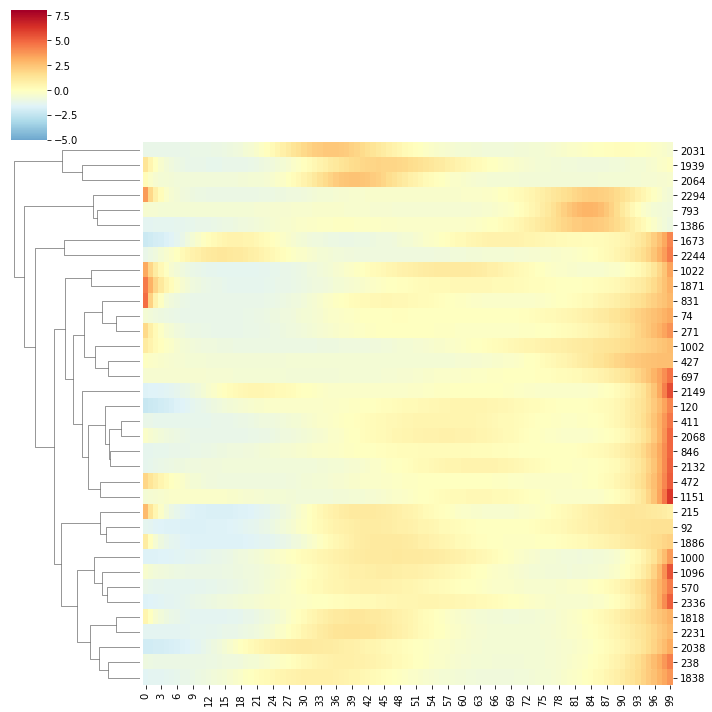

In [200]:
plt.rcParams['figure.figsize'] = [10, 20]

# z_scoreint or None, optional
# Either 0 (rows) or 1 (columns).





g =sns.clustermap(data=temp_3,
             metric='cityblock', #defualt euclidean   #canberra
             method='average',
            z_score=0,
           cmap='RdYlBu_r',
            vmax=8,
            vmin=-5,
            center=0,
               col_cluster=False      
           )

#plt.savefig('/Users/derekbogdanoff/Desktop/heatmap_spatial.svg', bbox_inches='tight')